# Analyzing and Visualizing Census Rent Data

See the data and map in action at http://geoffboeing.com/2015/11/landscape-us-rents/

I loaded and geocoded the 2014 ACS 1-year median contract rent data in [this notebook](load_geocode_rent_data.ipynb). Now, merge the data with 2010 ACS rents and 2010/2014 population data. Analyze it, visualize it, map it, and then save it to GeoJSON so we can make an interactive web map with Leaflet.

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm, matplotlib.font_manager as fm
import matplotlib.pyplot as plt, matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from geopandas import GeoDataFrame
from shapely.geometry import Point

%matplotlib inline

In [2]:
# define the fonts to use for plots
family = 'Myriad Pro'
title_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=14, weight='normal', stretch='normal')

In [3]:
# load the 2014 geolocated rent data
rent14 = pd.read_csv('data/rent_latlong.csv')
rent14 = rent14.rename(columns={'geo_id2':'geo_id_14'})
rent14 = rent14[['geo_id_14', 'msa_name', 'city_state', 'median_contract_rent', 'latitude', 'longitude']]

In [4]:
# load the 2010 rent data
rent10 = pd.read_csv('data/ACS_10_1YR_B25058_metro_micro/ACS_10_1YR_B25058.csv')
rent10 = rent10.rename(columns={'GEO.id':'geo_id', 
                            'GEO.id2':'geo_id_10', 
                            'GEO.display-label':'msa_name', 
                            'HD01_VD01':'median_rent_10',
                            'HD02_VD01':'margin_error'})
rent10 = rent10[['geo_id_10', 'median_rent_10']]

## Merge the 2014 and 2010 ACS rent data

Some census statistical area names and codes have changes between 2010 and 2014. Make a dict to map from the 2014 code to the 2010 code for those that changed. Others are brand new, and yet others were dropped by 2014... just ignore those because we can't compare them unless they have data for both years.

In [5]:
# create a dict to map 2014 codes to 2010 codes for those that changed
codes_14_10 = {  #2014_code:2010_code
    14010:14060, #bloomington il
    15680:30500, #lexington park md
    16060:32060, #marion il
    17200:30100, #lebanon nh
    25840:37820, #pendleton
    26090:26100, #holland
    29200:29140, #lafayette
    38240:43860, #pinehurst
    41400:20620, #salem oh
    48260:44600, #weirton
    49220:32270, #wisconsin rapids
    31080:31100, #los angeles
    42200:42060, #santa barbara
    46520:26180, #honolulu
    48260:44600} #steubenville

# create a new column to contain 2010 code
rent14['geo_id_10'] = rent14['geo_id_14'].map(lambda x: codes_14_10[x] if x in codes_14_10.keys() else x)

In [6]:
# now merge the two datasets on 2010 code
rent = pd.merge(rent14, rent10, on='geo_id_10')
rent.head()

,geo_id_14,msa_name,city_state,median_contract_rent,latitude,longitude,geo_id_10,median_rent_10
0,10140,"Aberdeen, WA Micro Area","Aberdeen, WA",626,46.975371,-123.815722,10140,562
1,10180,"Abilene, TX Metro Area","Abilene, TX",613,32.448736,-99.733144,10180,554
2,10300,"Adrian, MI Micro Area","Adrian, MI",556,41.897547,-84.037166,10300,537
3,10420,"Akron, OH Metro Area","Akron, OH",627,41.081445,-81.519005,10420,579
4,10500,"Albany, GA Metro Area","Albany, GA",480,31.578507,-84.155741,10500,477


In [7]:
# calculate the percentage that median rent changed between 2010 and 2014
rent['rent_change_pct'] = (rent['median_contract_rent'] / rent['median_rent_10'] - 1) * 100
rent.sort_values(by='rent_change_pct')[['msa_name', 'rent_change_pct']].head()

,msa_name,rent_change_pct
414,"Seneca, SC Micro Area",-14.417745
413,"Sebring, FL Metro Area",-11.992945
69,"Carson City, NV Metro Area",-9.015257
464,"Valdosta, GA Metro Area",-7.992895
442,"Talladega-Sylacauga, AL Micro Area",-7.049608


## Now load the population data

This file contains 2014 population estimates and 2010 population values from the census.

In [8]:
# load the population data
pops = pd.read_csv('data/PEP_2014_PEPANNRES/PEP_2014_PEPANNRES.csv', encoding='utf-8')
pops = pops.rename(columns={'GEO.id2':'geo_id_14', 
                              'rescen42010':'pop_10', 
                              'respop72014':'pop_est_14'})
pops = pops[['geo_id_14', 'pop_10', 'pop_est_14']]
pops.head()

,geo_id_14,pop_10,pop_est_14
0,10100,40602,42391
1,10140,72797,70818
2,10180,165252,168592
3,10220,37492,38005
4,10300,99892,99047


In [9]:
# merge the rent dataset with the population dataset
df = pd.merge(rent, pops, on='geo_id_14')
df.head()

,geo_id_14,msa_name,city_state,median_contract_rent,latitude,longitude,geo_id_10,median_rent_10,rent_change_pct,pop_10,pop_est_14
0,10140,"Aberdeen, WA Micro Area","Aberdeen, WA",626,46.975371,-123.815722,10140,562,11.387900,72797,70818
1,10180,"Abilene, TX Metro Area","Abilene, TX",613,32.448736,-99.733144,10180,554,10.649819,165252,168592
2,10300,"Adrian, MI Micro Area","Adrian, MI",556,41.897547,-84.037166,10300,537,3.538175,99892,99047
3,10420,"Akron, OH Metro Area","Akron, OH",627,41.081445,-81.519005,10420,579,8.290155,703200,703825
4,10500,"Albany, GA Metro Area","Albany, GA",480,31.578507,-84.155741,10500,477,0.628931,157308,154925


In [10]:
# calculate the percentage that population changed between 2010 and 2014
df['pop_change_pct'] = (df['pop_est_14'] / df['pop_10'] - 1) * 100
df.sort_values(by='pop_change_pct')[['msa_name', 'pop_change_pct']].head()

,msa_name,pop_change_pct
348,"Pine Bluff, AR Metro Area",-5.527738
142,"Farmington, NM Metro Area",-4.812986
377,"Roanoke Rapids, NC Micro Area",-4.371663
214,"Johnstown, PA Metro Area",-4.139088
277,"Martinsville, VA Micro Area",-3.207203


## Explore relationships in the data with some scatterplots

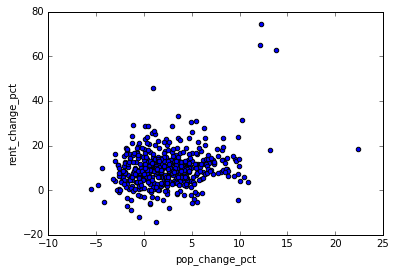

In [11]:
# percent change in rent vs percent change in population
df.plot(kind='scatter', x='pop_change_pct', y='rent_change_pct')

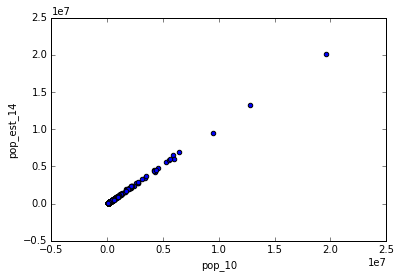

In [12]:
# 2014 population vs 2010 population
df.plot(kind='scatter', x='pop_10', y='pop_est_14')

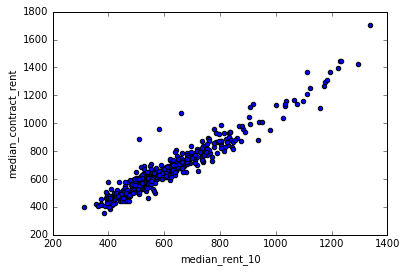

In [13]:
# 2014 median rent vs 2010 median rent
df.plot(kind='scatter', x='median_rent_10', y='median_contract_rent')

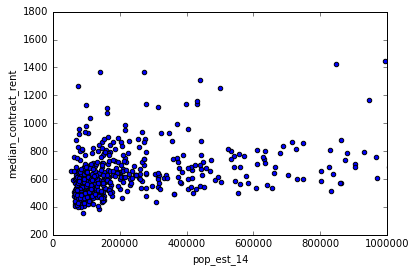

In [14]:
# 2014 median rent vs 2014 population
df.plot(kind='scatter', x='pop_est_14', y='median_contract_rent', xlim=[0, 1000000])

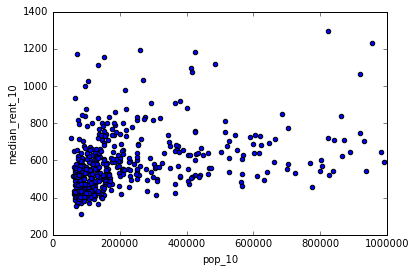

In [15]:
# 2010 median rent vs 2010 population
df.plot(kind='scatter', x='pop_10', y='median_rent_10', xlim=[0, 1000000])

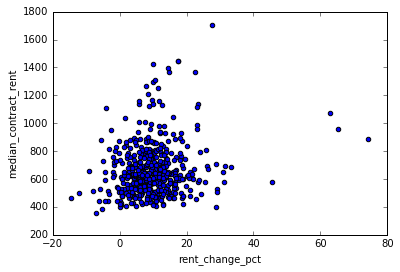

In [16]:
# 2014 median rent vs percent change in rent 2010-2014
df.plot(kind='scatter', x='rent_change_pct', y='median_contract_rent')

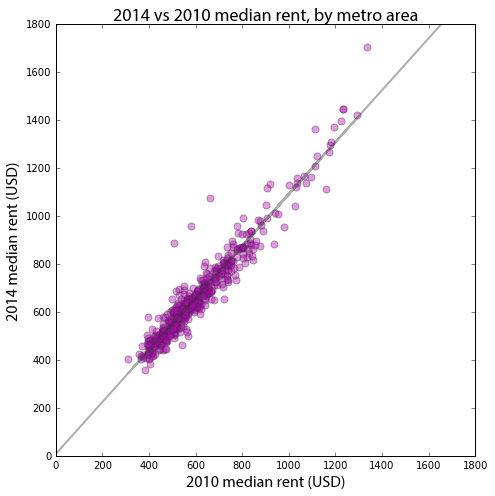

In [17]:
# plot 2014 median rent vs 2010 median rent
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
axis_min = 0
axis_max = 1800
    
# regress 2014 rent on 2010 rent
X = df['median_rent_10']
Y = df['median_contract_rent']
results = sm.OLS(Y, sm.add_constant(X)).fit()

# calculate estimated y values for regression line
X_line = X.copy()
X_line.loc[axis_min] = axis_min
X_line.loc[axis_max] = axis_max
Y_est = X_line * results.params[1] + results.params[0]

# draw points, regression line, and line of 1:1 linear relationship
#ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k-', color='k', alpha=0.3, linewidth=2)
ax.plot(X_line, Y_est, c='#333333', alpha=0.4, linewidth=2)
ax.scatter(X, Y, c='m', edgecolor='#333333', alpha=0.4, s=50)

ax.set_xlim([axis_min, axis_max])
ax.set_ylim([axis_min, axis_max])

ax.set_title('2014 vs 2010 median rent, by metro area', fontproperties=title_font)
ax.set_xlabel('2010 median rent (USD)', fontproperties=label_font)
ax.set_ylabel('2014 median rent (USD)', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/scatter-rent-change-2010-2014.png', dpi=300)
plt.show()

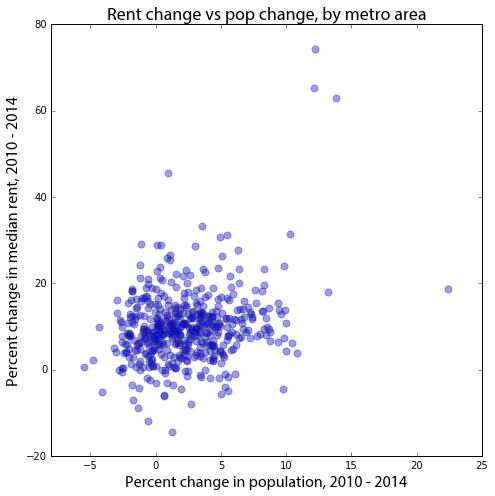

In [18]:
# plot percent change in median rent vs percent change in population, 2010-2014
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
    
# regress rent change rate on population change rate
X = df['pop_change_pct']
Y = df['rent_change_pct']
results = sm.OLS(Y, sm.add_constant(X)).fit()

# calculate estimated y values for regression line
X_line = X.copy()
X_line.loc[-10] = -10
X_line.loc[30] = 30
Y_est = X_line * results.params[1] + results.params[0]

# draw points, regression line
#ax.plot(X_line, Y_est, c='#333333', alpha=0.4, linewidth=2)
ax.scatter(X, Y, c='b', edgecolor='#333333', alpha=0.4, s=50)

ax.set_xlim([-8, 25])
ax.set_ylim([-20, 80])

ax.set_title('Rent change vs pop change, by metro area', fontproperties=title_font)
ax.set_xlabel('Percent change in population, 2010 - 2014', fontproperties=label_font)
ax.set_ylabel('Percent change in median rent, 2010 - 2014', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/scatter-rent-pop-change-2010-14.png', dpi=300)
plt.show()

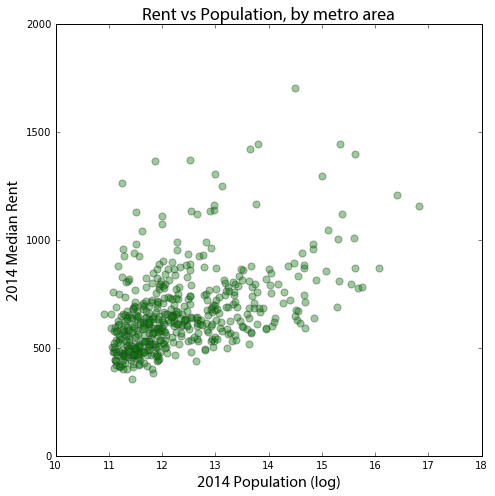

In [19]:
# plot 2014 median rent vs 2014 population
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
    
# regress rent on population
X = np.log(df['pop_est_14'])
Y = df['median_contract_rent']
results = sm.OLS(Y, sm.add_constant(X)).fit()

# calculate estimated y values for regression line
X_line = X.copy()
X_line.loc[0] = 0
X_line.loc[20] = 20
Y_est = X_line * results.params[1] + results.params[0]

# draw points, regression line
#ax.plot(X_line, Y_est, c='#333333', alpha=0.4, linewidth=2)
ax.scatter(X, Y, c='g', edgecolor='#333333', alpha=0.4, s=50)

ax.set_xlim([10, 18])
ax.set_ylim([0, 2000])

ax.set_title('Rent vs Population, by metro area', fontproperties=title_font)
ax.set_xlabel('2014 Population (log)', fontproperties=label_font)
ax.set_ylabel('2014 Median Rent', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/scatter-rent-pop-log-2010-14.png', dpi=300)
plt.show()

## Now map the point data over a USA basemap

In [20]:
# create categorical variables by dividing the data set into quantiles
num_bins = 5
bin_labels = range(num_bins)
df['rent_cat'] = pd.qcut(x=df['median_contract_rent'], q=num_bins, labels=bin_labels)
df['rent_change_cat'] = pd.qcut(x=df['rent_change_pct'], q=num_bins, labels=bin_labels)
df['pop_change_cat'] = pd.qcut(x=df['pop_change_pct'], q=num_bins, labels=bin_labels)
df[['msa_name', 'rent_cat', 'rent_change_cat', 'pop_change_cat']].head()

,msa_name,rent_cat,rent_change_cat,pop_change_cat
0,"Aberdeen, WA Micro Area",2,3,0
1,"Abilene, TX Metro Area",2,3,2
2,"Adrian, MI Micro Area",1,0,0
3,"Akron, OH Metro Area",2,2,1
4,"Albany, GA Metro Area",0,0,0


In [21]:
# define basemap colors
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#666666'
border_color = '#999999'

# get colors between blue and red, one for each bin
color_map = cm.get_cmap('brg')
increments = [x*.6/float(num_bins) for x in range(num_bins)] #only colors between blue and red (no green)
color_list = color_map(increments).tolist() 

In [22]:
# function to draw the basemap and scatterplot the point data
def draw_map(cat, title):
    # specify map width and height with approx US dimensions
    map_width_m = 5000 * 1000 #3500 km
    map_height_m = 3500 * 1000 #2500 km
    plt.figure(figsize=[10, 10*(map_height_m/float(map_width_m))]) #make plot the same height:width ratio

    # Albers Conical Equal Area projection for US
    m = Basemap(ellps='WGS84', projection='aea', lat_1=33, lat_2=45, lon_0=-98.4, lat_0=39,
                width=map_width_m, height=map_height_m, resolution='l', area_thresh=10000, fix_aspect=False)

    m.drawcoastlines(color=coastline_color)
    m.drawcountries(color=border_color)
    m.drawstates(color=border_color)
    m.fillcontinents(color=land_color, lake_color=water_color)
    m.drawmapboundary(fill_color=water_color)

    # project and plot our lat-long data with each bin getting its own color
    for color, n in zip(color_list, range(num_bins)):
        subset = df[df[cat]==n]
        x, y = m(np.array(subset['longitude']), np.array(subset['latitude']))
        m.scatter(x=x, y=y, s=200, color=color, edgecolor='#555555', alpha=0.7, zorder=10)

    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('images/{}.png'.format(title), dpi=300)
    plt.show()

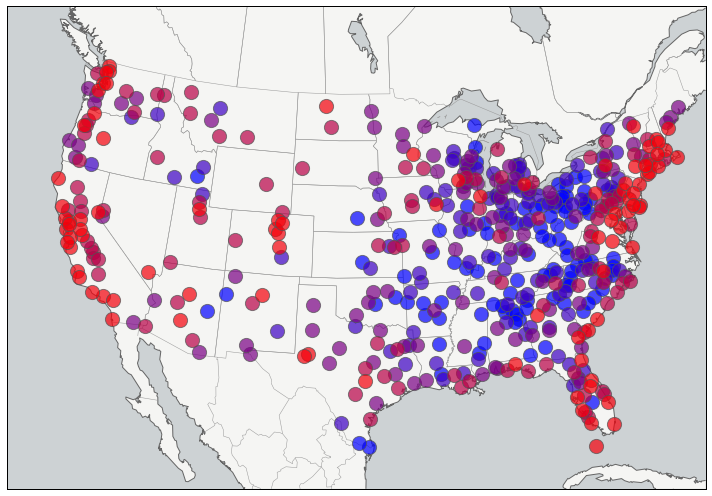

In [23]:
# draw the map of median rent per metro/micro area, colored by nationwide quintile
draw_map('rent_cat', 'median_rent_msa')

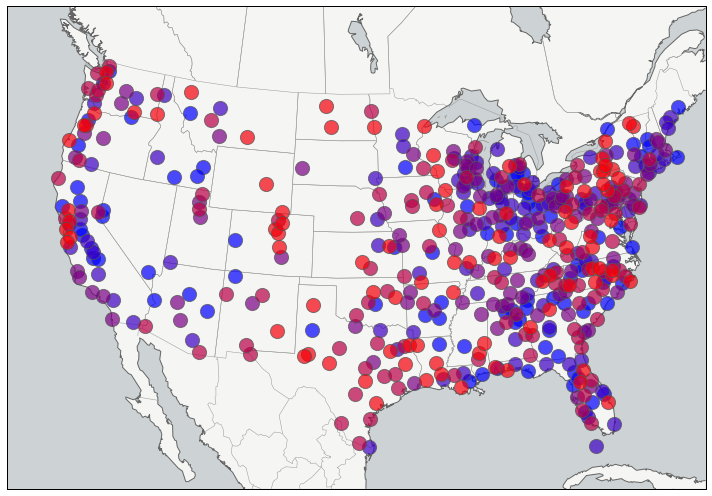

In [24]:
# draw the map of % change in median rent per metro/micro area, colored by nationwide quintile
draw_map('rent_change_cat', 'rent_change_msa')

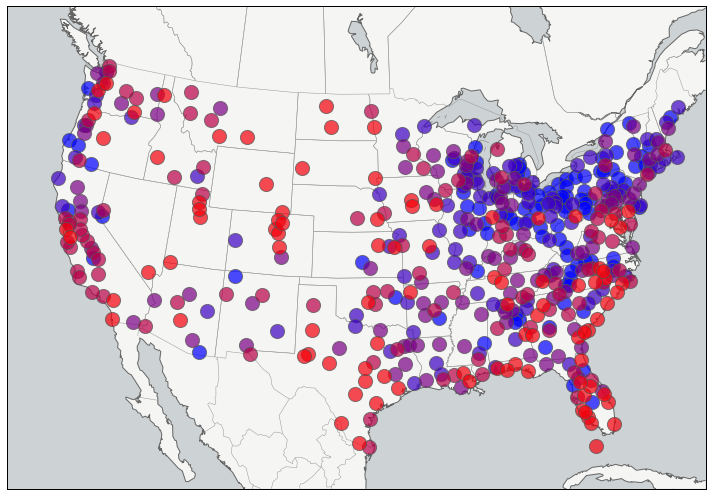

In [25]:
# draw the map of % change in population per metro/micro area, colored by nationwide quintile
draw_map('pop_change_cat', 'pop_change_msa')

## Format everything nicely for display in an interactive web map

In [26]:
# make the percents look nice for display
def format_pct(pct):
    pct = round(pct, 1)
    prefix = '+' if pct > 0 else ''
    return '{}{}%'.format(prefix, pct)

df['rent_change_pct_s'] = df['rent_change_pct'].map(format_pct)
df['pop_change_pct_s'] = df['pop_change_pct'].map(format_pct)
df[['pop_change_pct_s', 'rent_change_pct_s']].head()

,pop_change_pct_s,rent_change_pct_s
0,-2.7%,+11.4%
1,+2.0%,+10.6%
2,-0.8%,+3.5%
3,+0.1%,+8.3%
4,-1.5%,+0.6%


In [27]:
# make the pops look nice for display
def format_pop(pop):
    return '{:,}'.format(pop)

df['pop_10_s'] = df['pop_10'].map(format_pop)
df['pop_est_14_s'] = df['pop_est_14'].map(format_pop)
df[['pop_10_s', 'pop_est_14_s']].head()

,pop_10_s,pop_est_14_s
0,"72,797","70,818"
1,"165,252","168,592"
2,"99,892","99,047"
3,"703,200","703,825"
4,"157,308","154,925"


In [28]:
# make the rents look nice for display
def format_rent(rent):
    return '${:,}'.format(rent)

df['median_contract_rent_s'] = df['median_contract_rent'].map(format_rent)
df['median_rent_10_s'] = df['median_rent_10'].map(format_rent)
df[['median_contract_rent_s', 'median_rent_10_s']].sort_values(by='median_contract_rent_s').head()

,median_contract_rent_s,median_rent_10_s
375,"$1,007",$952
284,"$1,011",$940
64,"$1,041","$1,025"
411,"$1,046",$903
287,"$1,075",$660


## Display some descriptive tables

In [29]:
df.columns

Index(['geo_id_14', 'msa_name', 'city_state', 'median_contract_rent',
       'latitude', 'longitude', 'geo_id_10', 'median_rent_10',
       'rent_change_pct', 'pop_10', 'pop_est_14', 'pop_change_pct', 'rent_cat',
       'rent_change_cat', 'pop_change_cat', 'rent_change_pct_s',
       'pop_change_pct_s', 'pop_10_s', 'pop_est_14_s',
       'median_contract_rent_s', 'median_rent_10_s'],
      dtype='object')

In [30]:
# create a new dataframe with nice column names to display data for publication
ds = df[['median_contract_rent_s', 'median_contract_rent', 'city_state', 'pop_change_pct', 'pop_change_pct_s',
         'rent_change_pct', 'rent_change_pct_s', 'pop_est_14']]
ds = ds.rename(columns={'median_contract_rent_s':'2014 Median Rent',
                        'city_state':'Metro Area',
                        'pop_est_14':'2014 Population',
                        'rent_change_pct_s':'Change since 2010',
                        'pop_change_pct_s':'Pop. Change',})
cols = ['Metro Area', '2014 Median Rent', 'Change since 2010']

In [31]:
# the metros with the highest median rents
metros = ds.sort_values(by='median_contract_rent', ascending=False)[cols].reset_index()
metros.drop('index', axis=1, inplace=True)
metros.index = metros.index + 1
metros.head(15)

,Metro Area,2014 Median Rent,Change since 2010
1,"San Jose, CA","$1,706",+27.7%
2,"Honolulu, HI","$1,447",+17.4%
3,"San Francisco, CA","$1,445",+17.4%
4,"Oxnard, CA","$1,422",+9.9%
5,"Washington, DC","$1,398",+14.4%
6,"Santa Cruz, CA","$1,370",+14.7%
7,"Napa, CA","$1,365",+22.6%
8,"Santa Maria, CA","$1,307",+10.5%
9,"San Diego, CA","$1,295",+9.9%
10,"Key West, FL","$1,266",+7.8%


In [32]:
# the metros with the lowest median rents
metros = ds.sort_values(by='median_contract_rent', ascending=True)[cols].reset_index()
metros.drop('index', axis=1, inplace=True)
metros.index = metros.index + 1
metros.head(10)

,Metro Area,2014 Median Rent,Change since 2010
1,"Talladega, AL",$356,-7.0%
2,"Johnstown, PA",$385,-5.2%
3,"Portsmouth, OH",$402,0.0%
4,"Opelousas, LA",$402,+28.8%
5,"Lumberton, NC",$404,+11.0%
6,"Martinsville, VA",$406,+4.9%
7,"Albertville, AL",$410,+2.0%
8,"Roanoke Rapids, NC",$412,+9.9%
9,"Gallup, NM",$415,+13.1%
10,"Mount Airy, NC",$416,+0.5%


In [33]:
# the metros with the largest relative rise in median rent
metros = ds.sort_values(by='rent_change_pct', ascending=False)[cols].reset_index()
metros.drop('index', axis=1, inplace=True)
metros.index = metros.index + 1
metros.head(10)

,Metro Area,2014 Median Rent,Change since 2010
1,"Odessa, TX",$887,+74.3%
2,"Minot, ND",$958,+65.2%
3,"Midland, TX","$1,075",+62.9%
4,"Athens, TX",$578,+45.6%
5,"Morehead City, NC",$689,+33.3%
6,"Bismarck, ND",$695,+31.4%
7,"Pinehurst, NC",$576,+31.2%
8,"Victoria, TX",$654,+30.8%
9,"Meridian, MS",$505,+29.2%
10,"Carbondale, IL",$530,+29.0%


In [34]:
# the metros with the largest relative drop in median rent
metros = ds.sort_values(by='rent_change_pct', ascending=True)[cols].reset_index()
metros.drop('index', axis=1, inplace=True)
metros.index = metros.index + 1
metros.head(10)

,Metro Area,2014 Median Rent,Change since 2010
1,"Seneca, SC",$463,-14.4%
2,"Sebring, FL",$499,-12.0%
3,"Carson City, NV",$656,-9.0%
4,"Valdosta, GA",$518,-8.0%
5,"Talladega, AL",$356,-7.0%
6,"Show Low, AZ",$445,-6.1%
7,"Stevens Point, WI",$527,-5.9%
8,"Kapaa, HI",$882,-5.7%
9,"Johnstown, PA",$385,-5.2%
10,"Jacksonville, NC",$733,-5.1%


In [35]:
# update ds for population data
ds = df[['median_contract_rent_s', 'median_contract_rent', 'city_state', 'pop_change_pct', 'pop_change_pct_s',
         'rent_change_pct', 'rent_change_pct_s', 'pop_est_14', 'pop_est_14_s']]
ds = ds.rename(columns={'median_contract_rent_s':'2014 Median Rent',
                        'city_state':'Metro Area',
                        'pop_est_14_s':'2014 Population',
                        'rent_change_pct_s':'Rent Change since 2010',
                        'pop_change_pct_s':'Pop. Change since 2010',})
cols = ['Metro Area', 'Pop. Change since 2010', '2014 Median Rent', 'Rent Change since 2010']

In [36]:
# the metros with the largest relative gain in population
metros = ds.sort_values(by='pop_change_pct', ascending=False)[cols].reset_index()
metros.drop('index', axis=1, inplace=True)
metros.index = metros.index + 1
metros.head(10)

,Metro Area,Pop. Change since 2010,2014 Median Rent,Rent Change since 2010
1,"The Villages, FL",+22.4%,$603,+18.7%
2,"Midland, TX",+13.8%,"$1,075",+62.9%
3,"Austin, TX",+13.2%,$895,+18.1%
4,"Odessa, TX",+12.2%,$887,+74.3%
5,"Minot, ND",+12.1%,$958,+65.2%
6,"Myrtle Beach, SC",+10.9%,$668,+3.7%
7,"Dunn, NC",+10.5%,$570,+6.1%
8,"Bismarck, ND",+10.3%,$695,+31.4%
9,"St. George, UT",+10.0%,$773,+4.3%
10,"Auburn, AL",+10.0%,$591,+10.7%


In [37]:
# the metros that lost the largest percentage of their population
metros = ds.sort_values(by='pop_change_pct', ascending=True)[cols].reset_index()
metros.drop('index', axis=1, inplace=True)
metros.index = metros.index + 1
metros.head(10)

,Metro Area,Pop. Change since 2010,2014 Median Rent,Rent Change since 2010
1,"Pine Bluff, AR",-5.5%,$426,+0.5%
2,"Farmington, NM",-4.8%,$610,+2.2%
3,"Roanoke Rapids, NC",-4.4%,$412,+9.9%
4,"Johnstown, PA",-4.1%,$385,-5.2%
5,"Martinsville, VA",-3.2%,$406,+4.9%
6,"Flint, MI",-3.0%,$542,+4.0%
7,"Palatka, FL",-3.0%,$559,+16.2%
8,"Sierra Vista, AZ",-3.0%,$660,+13.2%
9,"Portsmouth, OH",-2.8%,$402,0.0%
10,"Aberdeen, WA",-2.7%,$626,+11.4%


In [38]:
cols = ['Metro Area', '2014 Population', '2014 Median Rent', 'Rent Change since 2010']

In [39]:
# the most populous metros
metros = ds.sort_values(by='pop_est_14', ascending=False)[cols].reset_index()
metros.drop('index', axis=1, inplace=True)
metros.index = metros.index + 1
metros.head(20)

,Metro Area,2014 Population,2014 Median Rent,Rent Change since 2010
1,"New York, NY","20,092,883","$1,158",+11.9%
2,"Los Angeles, CA","13,262,220","$1,208",+8.5%
3,"Chicago, IL","9,554,598",$872,+8.5%
4,"Dallas, TX","6,954,330",$784,+13.5%
5,"Houston, TX","6,490,180",$777,+12.9%
6,"Philadelphia, PA","6,051,170",$870,+9.3%
7,"Washington, DC","6,033,737","$1,398",+14.4%
8,"Miami, FL","5,929,819","$1,011",+7.6%
9,"Atlanta, GA","5,614,323",$794,+8.3%
10,"Boston, MA","4,732,161","$1,122",+8.7%


## Lastly save everything to js for web mapping

In [40]:
# convert dataframe to geojson and save to js file
gdf = GeoDataFrame(df)
gdf['geometry'] = gdf.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
cols = ['geo_id_14', 'latitude', 'longitude', 'median_contract_rent', 'median_rent_10',
        'pop_10', 'pop_est_14', 'rent_change_pct', 'pop_change_pct', 'geo_id_10']
gdf = gdf.drop(cols, axis=1, inplace=False)
geojson = gdf.to_json()
output_filename = 'leaflet/rent-data.js'
with open(output_filename, 'w') as output_file:
    output_file.write('var dataset = {};'.format(geojson, separators=(',',':')))

In [41]:
# turn a list of mpl rgba color codes into a list of hex color codes
def rgb_color_list_to_hex(color_list):
    # mpl does rgb as 0-1 and uses a 4th element to represent alpha
    # loop through each color and multiply each of the first 3 elements by 255 to get r, g, b in 0-255
    color_list_rgb = [[int(x*255) for x in c[0:3]] for c in color_list]
    # now convert each r, g, and b to hex and put in string
    hex_colors = ['#{:02X}{:02X}{:02X}'.format(rgb[0], rgb[1], rgb[2]) for rgb in color_list_rgb]
    return hex_colors

hex_colors = rgb_color_list_to_hex(color_list)
hex_colors

['#0000FF', '#3C00C3', '#790085', '#B80047', '#F3000B']

In [42]:
# get value ranges covered by bins (a categorical variable) in a dataframe
def bins_to_value_ranges(df, cat_column, val_column, format_string, first_format_string='<{}', 
                         last_format_string='{}+', split_string='&ndash;', first_inclusive=False, last_inclusive=True):
    labels = []
    categories = sorted(df[cat_column].unique())
    # for each bin/category
    for cat in categories:
        # get the min and max values within this bin and format as a string
        min_val = df[df[cat_column]==cat][val_column].min()
        max_val = df[df[cat_column]==cat][val_column].max()
        labels.append(format_string.format(min_val, max_val))
    # if the first/last range should be inclusive, change it from min-max
    if first_inclusive:
        labels[0] = first_format_string.format(labels[0].split(split_string)[-1])
    if last_inclusive:
        labels[-1] = last_format_string.format(labels[-1].split(split_string)[0])
    return labels

rent_labels = bins_to_value_ranges(df, 'rent_cat', 'median_contract_rent', '${:,}&ndash;{:,}')
rent_change_labels = bins_to_value_ranges(df, 'rent_change_cat', 'rent_change_pct', '{:.1f}&ndash;{:.1f}%', 
                                          split_string='&ndash;', first_inclusive=True, last_inclusive=True,
                                          first_format_string='< {}', last_format_string='> {}%')

print(rent_labels)
print(rent_change_labels)

['$356&ndash;517', '$518&ndash;598', '$599&ndash;660', '$666&ndash;786', '$787+']
['< 4.2%', '4.2&ndash;8.0%', '8.0&ndash;10.6%', '10.6&ndash;14.3%', '> 14.4%']


In [43]:
# create a dict defining category properties for rent bins
rent_properties = {}
for category, label, color in zip(bin_labels, rent_labels, hex_colors):
    rent_properties[category] = {'label':label, 'color':color}
rent_properties

{0: {'color': '#0000FF', 'label': '$356&ndash;517'},
 1: {'color': '#3C00C3', 'label': '$518&ndash;598'},
 2: {'color': '#790085', 'label': '$599&ndash;660'},
 3: {'color': '#B80047', 'label': '$666&ndash;786'},
 4: {'color': '#F3000B', 'label': '$787+'}}

In [44]:
# create a dict defining category properties for the percent change in rent
rent_change_properties = {}
for category, label, color in zip(bin_labels, rent_change_labels, hex_colors):
    rent_change_properties[category] = {'label':label, 'color':color}
rent_change_properties

{0: {'color': '#0000FF', 'label': '< 4.2%'},
 1: {'color': '#3C00C3', 'label': '4.2&ndash;8.0%'},
 2: {'color': '#790085', 'label': '8.0&ndash;10.6%'},
 3: {'color': '#B80047', 'label': '10.6&ndash;14.3%'},
 4: {'color': '#F3000B', 'label': '> 14.4%'}}

In [45]:
# save the properties to a js file for leaflet to use
with open('leaflet/category-properties.js', 'w') as output_file:
    output_file.write('var rentCatProps = {};\n'.format(rent_properties, separators=(',',':')))
    output_file.write('var rentChangeCatProps = {};'.format(rent_change_properties, separators=(',',':')))

See the data and map at http://geoffboeing.com/2015/11/landscape-us-rents/